In [4]:
import os
import io
import random
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import colorcet as cc
import seaborn as sns
import numba
import umap
import time
sns.set(rc={'figure.figsize':(12,8)})
palette = sns.color_palette("bright", 15)
palette2 = sns.color_palette("dark", 10)
palette3 = sns.color_palette(cc.glasbey, n_colors=20)


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/

In [23]:
SMI2LABEL = {'c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)CCC3)nc1': 1,
 'COc1ncc2cc(C(=O)Nc3cc(C(O)=NCc4cccc(Cl)c4)ccc3Cl)c(O)nc2n1': 2,
 'CC1CC2C3CC=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO': 3,
 'C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12': 4,
 'CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C': 5,
 'Cc1csc(-c2nnc(Nc3ccc(Oc4ncccc4-c4cc[nH]c(=N)n4)cc3)c3ccccc23)c1': 6,
 'O=C(c1ccccc1)N1CCC(CCCCN=C(O)C=Cc2cccnc2)CC1': 7,
 'CC(C)N=C(O)N1CCC(N=C2Nc3cc(F)ccc3N(CC(F)F)c3ccc(Cl)cc32)C1': 8,
 'CS(C)=O': 'control'}
SOURCE_LIST = ['source_2',  'source_3', 'source_5', 'source_6', 'source_7', 'source_8', 'source_11']

In [6]:
# For dropping features with abnormal standard deviation
def drop_bad_columns(df):
    cols = [c for c in df.columns if "Metadata_" not in c]
    stdev = [df[c].std() for c in cols]

    cols_to_drop = []
    cols_to_drop.extend([cols[i] for i, s in enumerate(stdev) if s < 0.1 or s > 5])
    cols_to_drop.extend([c for c in cols if "Nuclei_Correlation_RWC" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Correlation_Manders" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_14" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_15" in c])
    cols_to_drop.extend([c for c in cols if "Nuclei_Granularity_16" in c])

    df = df[[c for c in df.columns if c not in cols_to_drop]]
    return df, cols_to_drop

In [7]:
# Postprocessing

from pycytominer import normalize
from pycytominer.operations.transform import Spherize
from pycytominer.operations.transform import RobustMAD

def robustMAD(df):
    rmad = RobustMAD()
    rmad.fit(df)
    return rmad.transform(df)
    
def spherize(df):
    spherize = Spherize()
    spherize.fit(df)
    return spherize.transform(df)

def normalizer(df):
    normalized_df = normalize(
    profiles=data_df,
    meta_features="infer",
    method="mad_robustize"
)
    return normalized_df

# plate-wise process

def plate_wise_spherize_and_normailize(df, plate_col="Metadata_Plate", feature_cols=None, is_spherize=True, is_normalize=True):
    if not feature_cols:
        feature_cols = [c for c in df.columns if not c.startswith('Metadata_')]
    else:
        feature_cols = [c for c in df.columns if c.startswith(feature_cols)]
    for plate in tqdm(df[plate_col].unique()):
        plate_df = df.loc[df[plate_col] == plate]
        if is_spherize:
            plate_df.loc[:, feature_cols] = spherize(plate_df[feature_cols])
        if is_normalize:
            plate_df.loc[:, feature_cols] = robustMAD(plate_df[feature_cols])
        df.loc[df[plate_col] == plate, feature_cols] = plate_df[feature_cols]
    return df

# Combine-fov to well profiles: ONLY used in micon features

def average_wells(df, feature_cols=None):
    if not feature_cols:
        feature_cols = [c for c in df.columns if not c.startswith('Metadata_')]
    else:
        feature_cols = [c for c in df.columns if c.startswith(feature_cols)]
    index_col = ['Metadata_Plate', 'Metadata_Well']
    index_keys = df[index_col].drop_duplicates()
    print(len(index_keys))
    non_feature_cols = [c for c in df.columns if not c in feature_cols and c != 'Metadata_Fov']
    full_cols = non_feature_cols + feature_cols
    res_values = []
    for _, _df in tqdm(index_keys.iterrows()):
        plate = _df['Metadata_Plate']
        well = _df['Metadata_Well']
        well_level_df = df.loc[(df['Metadata_Plate'] == plate) & (df['Metadata_Well'] == well)]
        avg_feature_df = well_level_df[feature_cols].mean(axis=0).tolist()
        meta_df = well_level_df[non_feature_cols].iloc[0].tolist()
        values = meta_df + avg_feature_df
        res_values.append(values)
    averaged_df = pd.DataFrame(res_values, columns = full_cols)
    return averaged_df

# Get MOA dict (inchikey to moa target)

JP_TARGET = pd.read_csv("JUMP-Target-2_compound_metadata_with_cp0016_inchikey.csv")
INCHIKEY2MOA = dict(zip(JP_TARGET['Metadata_InChIKey'], JP_TARGET['target']))
def get_moa(inchikeys):
    if inchikeys in INCHIKEY2MOA:
        return INCHIKEY2MOA[inchikeys]
    else:
        return np.nan

def read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_feat_", is_moa=False):
    df_check = pd.read_parquet(cpfname)
    df_check["Metadata_Fov"] = df_check["Metadata_Fov"].astype(int)
    if is_moa:
        df_check["Metadata_Moa"] = df_check["Metadata_InChIKey"].apply(lambda x: get_moa(x)).tolist()
    with open(fname, "rb") as f:
        emb, fname = pkl.load(f)

    f_name = []
    for x in fname:
        [f_name.extend([t.split("$")]) for t in x]

    df_emb = pd.DataFrame({"Metadata_Plate": [x[2] for x in f_name], "Metadata_Well": [x[3] for x in f_name], "Metadata_Fov": [int(x[4]) for x in f_name]})
    for i in range(f_dim):
        df_emb = pd.concat([df_emb, pd.DataFrame({f"{feature_cols}{i}": emb[:, i]})], axis=1)

    df_check = df_check.merge(df_emb, on=["Metadata_Plate", "Metadata_Well", "Metadata_Fov"])
    return df_check

In [8]:
def generate_source_split(X, Y, Y_s, Y_b, source):
    X_train, Y_train, Y_s_train, Y_b_train = X[Y_s != source], Y[Y_s != source], Y_s[Y_s != source], Y_b[Y_s != source]
    X_test, Y_test, Y_s_test, Y_b_test = X[Y_s == source], Y[Y_s == source], Y_s[Y_s == source], Y_b[Y_s == source]
    
    return X_train, X_test, (Y_train, Y_s_train, Y_b_train), (Y_test, Y_s_test, Y_b_test)

def knn_classifier(df_train, df_test=None, n_neighbors=3, feature_col=["Emb_"], feature_col_test="Emb_", label_col="Metadata_Moa", label_col_test="Metadata_Moa"):
    df_train.dropna(subset=label_col, inplace=True)
    X = df_train[feature_col]
    y = df_train[label_col].to_numpy().astype('str')
    if df_test is not None:
        df_test.dropna(subset=label_col_test, inplace=True)
        X_test = df_test[feature_col_test]
        y_test = df_test[label_col_test].to_numpy().astype('str')
        X_train = X
        y_train = y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    print(f"Training samples: {len(X_train)}. Testing samples: {len(X_test)}")
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test).reshape(-1, 1)
    v = [accuracy_score(y_test[y_test == i], y_pred[y_test == i]) for i in sorted(np.unique(y_test))]
    v += [accuracy_score(y_test, y_pred)]
    acc = pd.DataFrame({"Class": sorted(np.unique(y_test)) + ["Total"], "Acc": v, "# of Samples": [len(y_test[y_test == i]) for i in sorted(np.unique(y_test))] + [len(y_test)] }, index=None)
    return acc

In [11]:
def generate_visualization(df_check, feature_cols, hues= None, type_viz='tsne', perplexity=30, model_name="Default", n_color=12):
    if isinstance(feature_cols, str):
        cols = [c for c in df_check.columns if c.startswith(feature_cols)]
    else:
        cols = feature_cols
    X = df_check[cols].values
    total_number_of_hue = len(hues)
    if total_number_of_hue == 1:
        Y_total = [df_check[hues[0]].to_numpy()]
    else:
        Y_total = [df_check[hue].to_numpy() for hue in hues]
    
    if type_viz == 'tsne':
        tsne = TSNE(perplexity=perplexity)
        X_embedded = tsne.fit_transform(X)
    elif type_viz == 'umap':
        reducer = umap.UMAP(n_neighbors=perplexity)
        X_embedded = reducer.fit_transform(X)
    else:
        raise Exception("{type_viz} not supported, choose from tsne/umap.")
        
    custom_palette = sns.color_palette(cc.glasbey, n_color)
    for hue_name, hue in zip(hues, Y_total):
        plt.figure()
        hue = [hue[i] if not pd.isnull(Y_total[0][i]) else np.nan for i in range(len(hue))]
        sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=hue, legend='full', palette=custom_palette)
        plt.title(f"{model_name}_by_{hue_name}", loc='center')
        plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)


In [10]:
def generate_visualization_two(df_check_1, df_check_2, feature_cols, hues=None, type_viz='tsne', \
                               perplexity=30, model_1_name="Default", model_2_name="Default_2", n_color=12, plot='all'):
    cols_1 = [c for c in df_check_1.columns if c.startswith(feature_cols)]
    cols_2 = [c for c in df_check_2.columns if c.startswith(feature_cols)]
    X_1 = df_check_1[cols_1].values
    X_2 = df_check_2[cols_2].values
    X_1_length = len(X_1)
    X = np.concatenate([X_1, X_2])
    total_number_of_hue = len(hues)
    if total_number_of_hue == 1:
        hue_1 = df_check_1[hues[0]]
        hue_2 = df_check_2[hues[0]]
        Y_1_total = [hue_1.to_numpy()]
        Y_2_total = [hue_2.to_numpy()]
        # Drop np.nan in hue order
        hue_1_order = [sorted(list(set(hue_1[~pd.isna(hue_1)].to_numpy().flatten())))]
        hue_2_order = [sorted(list(set(hue_2[~pd.isna(hue_2)].to_numpy().flatten())))]
    else:
        Y_1_total = [df_check_1[hue] for hue in hues]
        Y_2_total = [df_check_2[hue] for hue in hues]        
        hue_1_orders = [sorted(list(set(labels[~pd.isna(labels)].flatten()))) for labels in Y_1_total]
        hue_2_orders = [sorted(list(set(labels[~pd.isna(labels)].flatten()))) for labels in Y_2_total]
        
    if type_viz == 'tsne':
        tsne = TSNE(perplexity=perplexity)
        X_embedded = tsne.fit_transform(X)
    elif type_viz == 'umap':
        reducer = umap.UMAP(n_neighbors=perplexity)
        X_embedded = reducer.fit_transform(X)
    else:
        raise Exception("{type_viz} not supported, choose from tsne/umap.")
        
    X_1_embedded = X_embedded[:X_1_length]
    X_2_embedded = X_embedded[X_1_length:]
    
    custom_palette1 = sns.color_palette("bright", 15)
    custom_palette2 = sns.color_palette("dark", 15)
    for hue_name, label_1, label_2, hue_1, hue_2 in zip(hues, Y_1_total, Y_2_total, hue_1_order, hue_2_order):
        plt.figure()
        if plot == 'all':
            sns.scatterplot(x = X_1_embedded[:,0], y = X_1_embedded[:,1], hue=label_1, hue_order=hue_1, legend='full', palette=custom_palette1, markers = ['o'])
            sns.scatterplot(x = X_2_embedded[:,0], y = X_2_embedded[:,1], hue=label_2, hue_order=hue_2, style=label_2, legend='full', palette=custom_palette2, markers = ['^']*len(hue_2))
            plt.title(f"{model_1_name}_vs_{model_2_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)
        elif plot == 'one':
            sns.scatterplot(x = X_1_embedded[:,0], y = X_1_embedded[:,1], hue=label_1, hue_order=hue_1, legend='full', palette=custom_palette1, markers = ['o'])
            plt.title(f"{model_1_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)
        elif plot == 'two':
            sns.scatterplot(x = X_2_embedded[:,0], y = X_2_embedded[:,1], hue=label_2, hue_order=hue_2, legend='full', palette=custom_palette2, markers = ['o'])
            plt.title(f"{model_2_name}_by_{hue_name}", loc='center')
            plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol=4)

In [9]:
# Generate cp features 
profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)
selected_plates = []
_dframes = pd.DataFrame()

for _, row in tqdm(selected_plates.iterrows(), total=len(selected_plates)):
    s3_path = profile_formatter.format(**row.to_dict())
    df = pd.read_parquet(s3_path, storage_options={"anon": True})
    plate_name = row["Metadata_Plate"]
    df.to_parquet(f"jump_cp_target2/{plate_name}.parquet")
    _dframes = pd.concat([_dframes, df], axis=0, ignore_index=True)
    
dframes = []
for p in tqdm(metadata_target2['Metadata_Plate'].unique()):
    try:
        dframes.append(pd.read_parquet(f"jump_cp_compound/{p}.parquet"))
    except:
        dframes.append(pd.read_parquet(f"jump_cp_target2/{p}.parquet"))
dframes = pd.concat(dframes)

AttributeError: 'list' object has no attribute 'iterrows'

In [15]:
cpfname = "datasets/treated_moa.centered.parquet"
fname = "datasets/treated_moa_raw_embeddings_supcon_freeze_img_train_11000.pkl"

treated_moa_raw = read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_train_", is_moa=True)
treated_moa_raw_avg = average_wells(treated_moa_raw, feature_cols="micon_train_")
treated_moa_raw_avg_processed = plate_wise_spherize_and_normailize(treated_moa_raw_avg, feature_cols="micon_train_")

  0%|          | 0/280 [00:00<?, ?it/s]

In [14]:
cpfname = "datasets/treated_moa.centered.parquet"
fname = "datasets/treated_moa_raw_embeddings_supcon_freeze_img_test_ood_11000.pkl"

treated_moa_raw_test = read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_train_", is_moa=True)
treated_moa_raw_avg_test = average_wells(treated_moa_raw_test, feature_cols="micon_train_")
treated_moa_raw_avg_processed_test = plate_wise_spherize_and_normailize(treated_moa_raw_avg_test, feature_cols="micon_train_")

1718


0it [00:00, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

In [16]:
cpfname = "datasets/pos_control.centered.parquet"
fname = "datasets/pos_control_embeddings_supcon_freeze_img_test_10000.pkl"

pos_control = read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_train_", is_moa=True)
pos_control_avg = average_wells(pos_control, feature_cols="micon_train_")
pos_control_avg_processed = plate_wise_spherize_and_normailize(pos_control_avg, feature_cols="micon_train_")

7654


0it [00:00, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

In [17]:
cpfname = "datasets/pos_control.centered.parquet"
fname = "datasets/pos_control_embeddings_supcon_freeze_img_train_10000.pkl"

pos_control_train = read_file_embeddings(cpfname, fname, f_dim=512, feature_cols="micon_train_", is_moa=True)
pos_control_avg_train = average_wells(pos_control_train, feature_cols="micon_train_")
pos_control_avg_processed_train = plate_wise_spherize_and_normailize(pos_control_avg_train, feature_cols="micon_train_")

35136


0it [00:00, ?it/s]

  0%|          | 0/1012 [00:00<?, ?it/s]

/tmp/ipykernel_3870864/1228275304.py:22: UserWarning: The palette list has more values (80) than needed (6), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=hue, legend='full', palette=custom_palette)
/tmp/ipykernel_3870864/1228275304.py:22: UserWarning: The palette list has more values (80) than needed (8), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=hue, legend='full', palette=custom_palette)


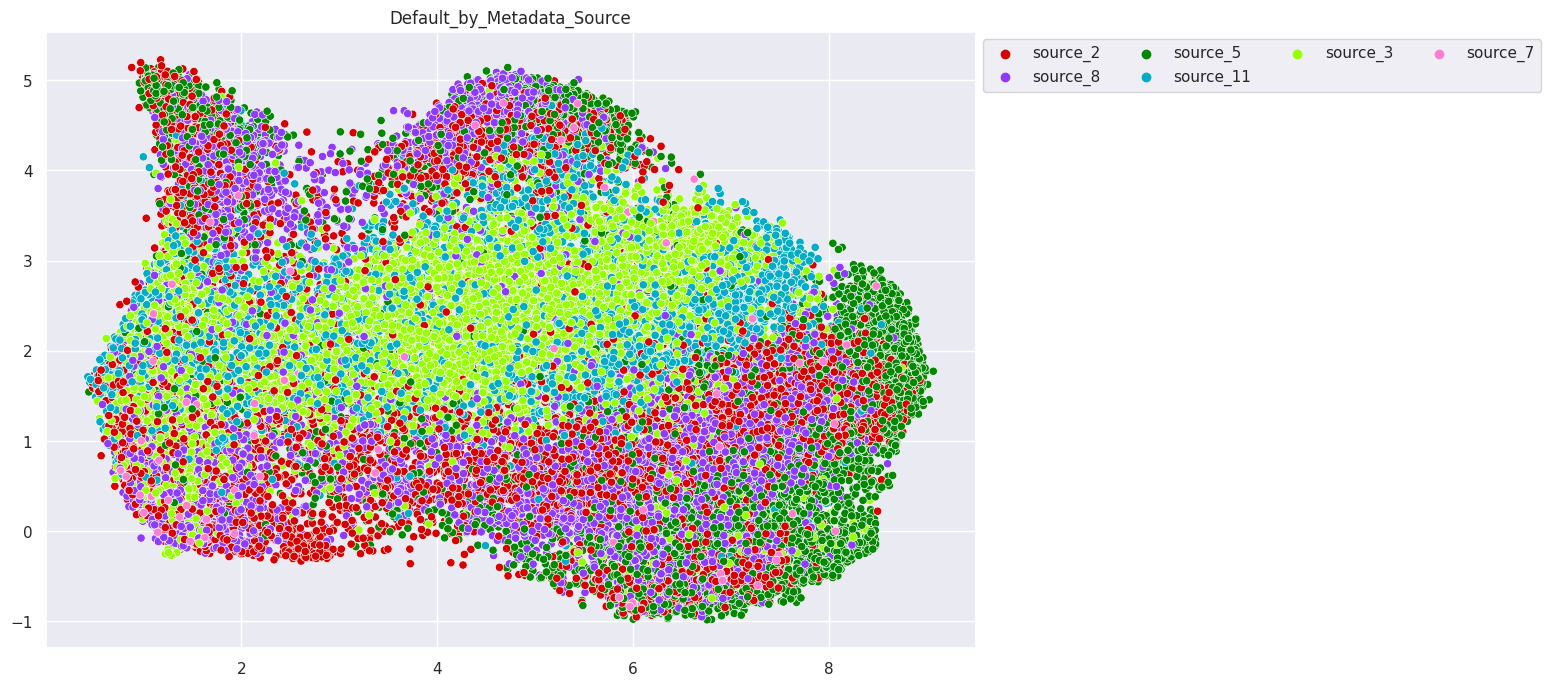

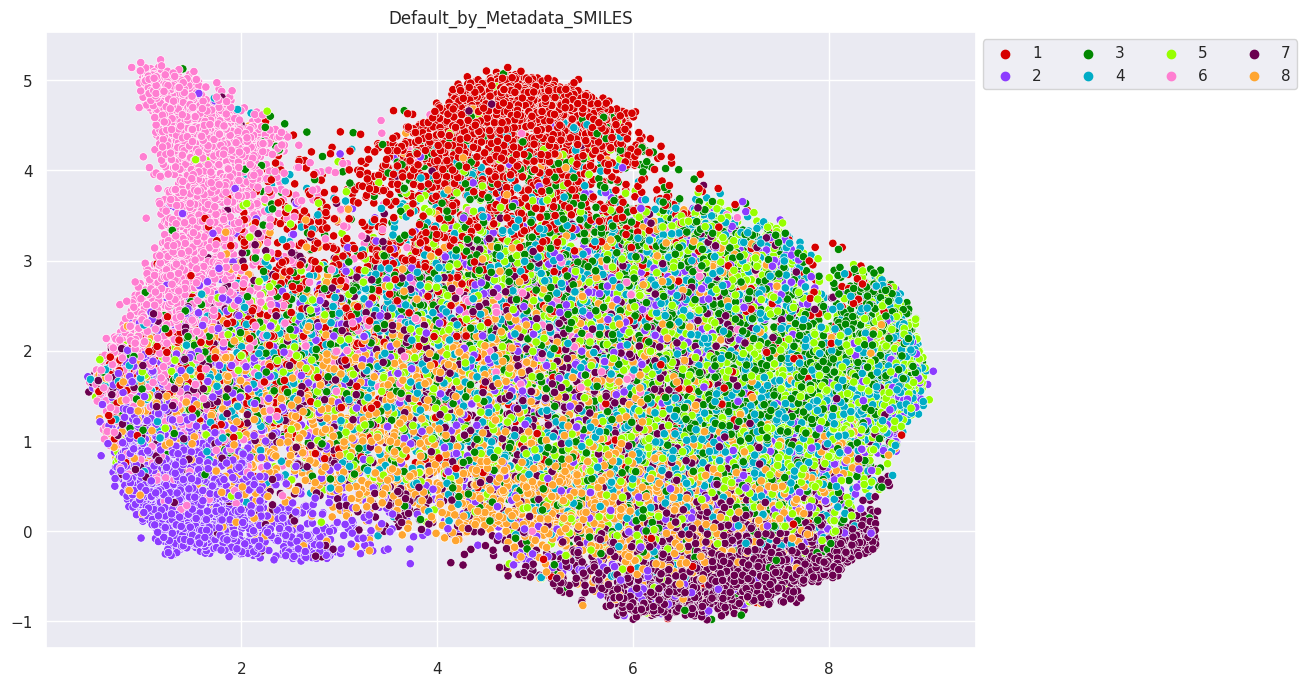

In [86]:
generate_visualization(pos_control_raw_old.loc[pos_control_raw_old['Metadata_SMILES'] != 'control'], feature_cols="micon_train_", hues=['Metadata_Source', 'Metadata_SMILES'], type_viz='umap', perplexity=30, model_name="Default", n_color=80)

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_1572232/1356681248.py:40: UserWarning: The palette list has more values (12) than needed (8), which may not be intended.
  sns.scatterplot(x = X_1_embedded[:,0], y = X_1_embedded[:,1], hue=label_1, hue_order=hue_1, legend='full', palette=custom_palette, markers = ['o'])
/tmp/ipykernel_1572232/1356681248.py:41: UserWarning: The palette list has more values (12) than needed (8), which may not be intended.
  sns.scatterplot(x = X_2_embedded[:,0], y = X_2_embedded[:,1], hue=label_2, hue_order=hue_2, style=label_2, legend='full', palette=custom_palette, markers = ['^']*l

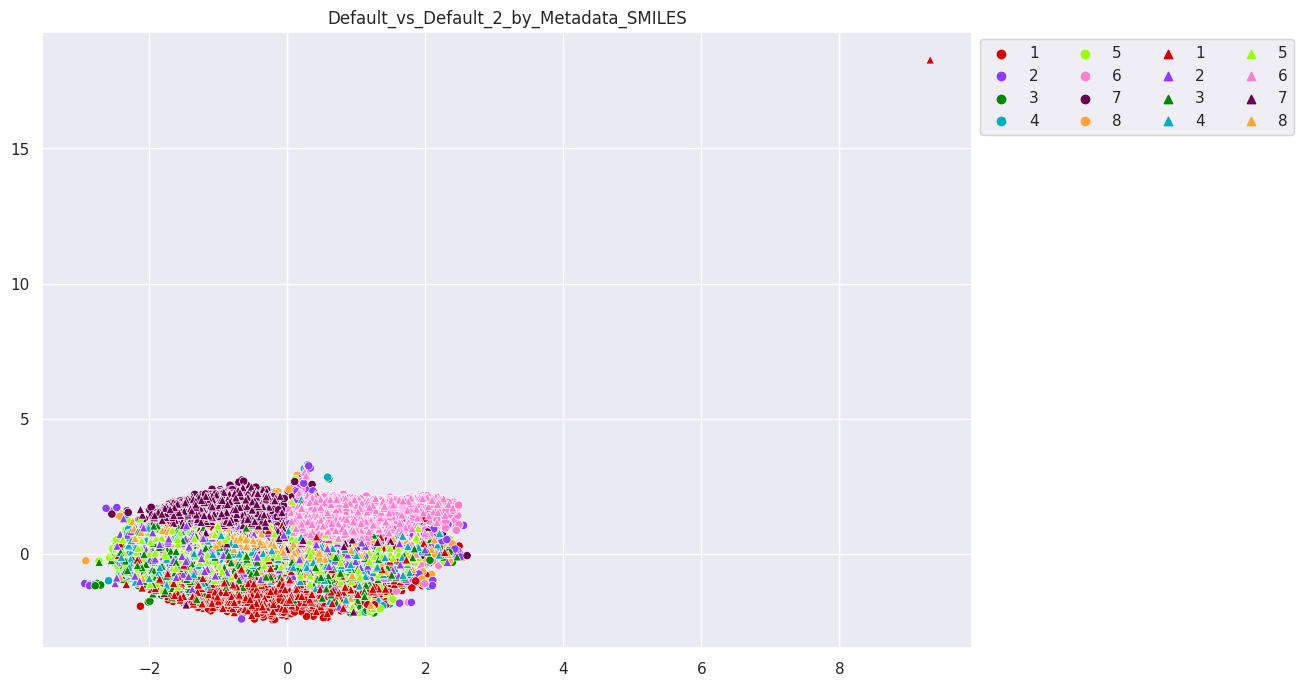

In [30]:
# pos_control_avg_train["Metadata_SMILES"] = pos_control_avg_train["Metadata_SMILES"].apply(lambda x: SMI2LABEL[x])
# pos_control_avg["Metadata_SMILES"] = pos_control_avg["Metadata_SMILES"].apply(lambda x: SMI2LABEL[x])
generate_visualization_two(pos_control_avg_train.loc[pos_control_avg_train["Metadata_SMILES"] != "control"], pos_control_avg.loc[pos_control_avg["Metadata_SMILES"] != "control"], hues = ["Metadata_SMILES"], feature_cols='micon_train_',  type_viz='tsne', perplexity=30)

In [84]:
treated_moa_raw


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Fov,Metadata_JCP2022,Metadata_agp_path,Metadata_dna_path,Metadata_er_path,Metadata_mito_path,...,micon_train_990,micon_train_991,micon_train_992,micon_train_993,micon_train_994,micon_train_995,micon_train_996,micon_train_997,micon_train_998,micon_train_999
0,source_6,p211012CPU2OS48hw384exp033JUMP,110000295609,G13,1,JCP2022_046524,110000295609/G13_i1_ch0.png,110000295609/G13_i1_ch1.png,110000295609/G13_i1_ch2.png,110000295609/G13_i1_ch3.png,...,0.038567,0.030491,-0.000143,-0.012365,0.016554,-0.011257,-0.008453,-0.005406,-0.017282,0.030534
1,source_6,p211012CPU2OS48hw384exp033JUMP,110000295609,G13,2,JCP2022_046524,110000295609/G13_i2_ch0.png,110000295609/G13_i2_ch1.png,110000295609/G13_i2_ch2.png,110000295609/G13_i2_ch3.png,...,0.033154,0.032567,-0.001446,-0.013120,0.013914,-0.013466,-0.010477,-0.005156,-0.017846,0.030231
2,source_6,p211012CPU2OS48hw384exp033JUMP,110000295609,G13,4,JCP2022_046524,110000295609/G13_i4_ch0.png,110000295609/G13_i4_ch1.png,110000295609/G13_i4_ch2.png,110000295609/G13_i4_ch3.png,...,0.035154,0.031179,-0.003530,-0.012408,0.012008,-0.012079,-0.006612,-0.003463,-0.016998,0.031499
3,source_6,p211012CPU2OS48hw384exp033JUMP,110000295609,G13,5,JCP2022_046524,110000295609/G13_i5_ch0.png,110000295609/G13_i5_ch1.png,110000295609/G13_i5_ch2.png,110000295609/G13_i5_ch3.png,...,0.037166,0.032827,-0.000466,-0.012705,0.015836,-0.011281,-0.005750,-0.005775,-0.019798,0.032040
4,source_6,p211012CPU2OS48hw384exp033JUMP,110000295609,G13,6,JCP2022_046524,110000295609/G13_i6_ch0.png,110000295609/G13_i6_ch1.png,110000295609/G13_i6_ch2.png,110000295609/G13_i6_ch3.png,...,0.034467,0.031598,-0.002548,-0.013630,0.011513,-0.012455,-0.009989,-0.007134,-0.016947,0.027332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7277,source_6,p211004CPU2OS48hw384exp031JUMP,110000296294,M24,5,JCP2022_085227,110000296294/M24_i5_ch0.png,110000296294/M24_i5_ch1.png,110000296294/M24_i5_ch2.png,110000296294/M24_i5_ch3.png,...,0.033875,0.032028,-0.000557,-0.013715,0.014325,-0.014411,-0.011019,-0.005246,-0.016829,0.030467
7278,source_3,CP59,BR5871c3,I01,5,JCP2022_085227,BR5871c3/I01_i5_ch0.png,BR5871c3/I01_i5_ch1.png,BR5871c3/I01_i5_ch2.png,BR5871c3/I01_i5_ch3.png,...,0.032913,0.031457,-0.004982,-0.013195,0.010990,-0.012352,-0.006491,-0.005635,-0.017311,0.030574
7279,source_8,J2,A1170462,A01,5,JCP2022_085227,A1170462/A01_i5_ch0.png,A1170462/A01_i5_ch1.png,A1170462/A01_i5_ch2.png,A1170462/A01_i5_ch3.png,...,0.035410,0.034376,0.002789,-0.011857,0.010705,-0.012234,-0.007867,-0.006793,-0.015631,0.025929
7280,source_2,20210823_Batch_10,1086291962,I01,5,JCP2022_085227,1086291962/I01_i5_ch0.png,1086291962/I01_i5_ch1.png,1086291962/I01_i5_ch2.png,1086291962/I01_i5_ch3.png,...,0.034636,0.032173,-0.003872,-0.015190,0.014110,-0.012351,-0.008075,-0.004677,-0.015792,0.030739


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_3870864/1228275304.py:22: UserWarning: The palette list has more values (80) than needed (8), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=hue, legend='full', palette=custom_palette)


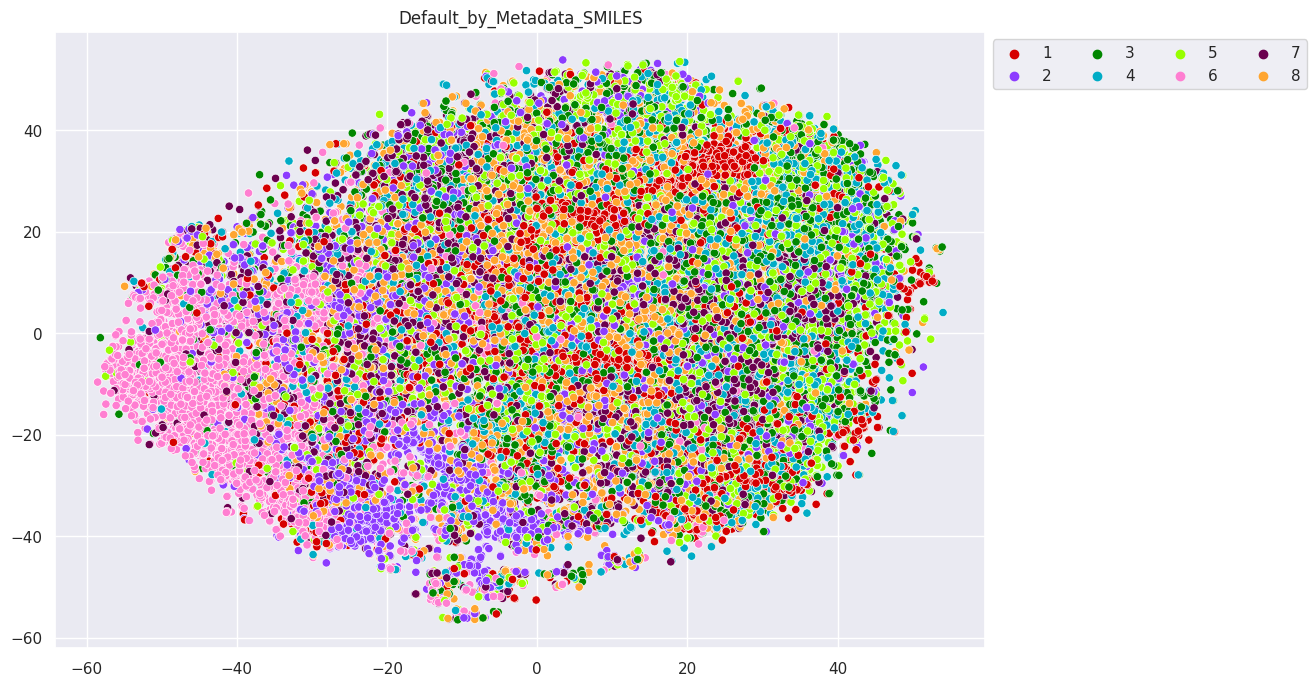

In [83]:
feature_col = [c for c in treated_moa_raw.columns if c.startswith("micon_train_")]
generate_visualization(pos_control_raw, feature_cols="micon_train_", hues=['Metadata_SMILES'], type_viz='tsne', perplexity=30, model_name="Default", n_color=80)

In [104]:
res = pd.DataFrame()
feature_col = [c for c in treated_moa_avg_processed.columns if not c.startswith("micon_train_") and not c.startswith("Metadata_")]
for i in range(2,10):
    acc = knn_classifier(treated_moa_avg_processed, n_neighbors=i, feature_col=feature_col, label_col="Metadata_Moa")
    res = pd.concat([res, acc], axis=1)

Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103
Training samples: 924. Testing samples: 103


In [75]:
res = pd.DataFrame()
feature_col = [c for c in treated_moa_raw.columns if not c.startswith("micon_train_") and not c.startswith("Metadata_")]
for i in range(2,10):
    acc = knn_classifier(treated_moa_raw, treated_moa_raw_test, n_neighbors=i, feature_col=feature_col, feature_col_test=feature_col, label_col="Metadata_Moa", label_col_test="Metadata_Moa")
    res = pd.concat([res, acc], axis=1)

Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362
Training samples: 4127. Testing samples: 362


In [16]:
metadata = pd.read_csv("/home/t-yeminyu/code/MICON/datasets/metadata/local_image_paths.csv")
compound = pd.read_csv("/home/t-yeminyu/code/MICON/datasets/metadata/compound.csv")
plates = pd.read_csv("/home/t-yeminyu/code/MICON/datasets/metadata/plate.csv.gz")

compound_plates = plates.loc[plates["Metadata_PlateType"] == "COMPOUND"]
metadata_compound = metadata.merge(compound_plates, on=['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate'])
metadata_compound_smi = metadata_compound.merge(compound, on=['Metadata_JCP2022'])
metadata_compound_smi = metadata_compound_smi.drop_duplicates()

target2_plates = plates.loc[plates["Metadata_PlateType"] == "TARGET2"]
target2_compound = metadata.merge(target2_plates, on=['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate'])
target2_compound_smi = target2_compound.merge(compound, on=['Metadata_JCP2022'])
target2_compound_smi = target2_compound_smi.drop_duplicates()